<a href="https://colab.research.google.com/github/AmonTonui/Final_Year_Project/blob/main/1stSOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Install Intrasom
  !pip install minisom

LOCAL_DEV = True
if LOCAL_DEV:
    sys.path.insert(0, '../')
    %load_ext autoreload

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=6515d1f7a791e86bdb4c0251a5c0bf2d8863e0cba83b9c649446fbce911c8710
  Stored in directory: /root/.cache/pip/wheels/c8/29/ba/ee521d9a6af783a1e1efb1831fe4afdf526613849b3f58175b
Successfully built minisom


Data Preprocessing and Feature Scaling

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np


data = pd.read_csv("educationnormalized_with_winners.csv")


party_colors = {
    'Conservative': (0, 0, 1),    # Blue
    'Labour': (1, 0, 0),          # Red
    'Liberal Democrat': (1, 0.65, 0),  # Orange
    'Green': (0, 0.5, 0),         # Dark Green
    'Independent': (0.5, 0.5, 0.5),  # Grey
    'The Brexit Party': (0.8, 0.4, 0), #light blue

}


#Data with Labels that I will use to map the result clusters
labeling_columns = ['Westminster Parliamentary constituencies', 'Winning Party', 'Winning Vote Share']
features = data.drop(columns=labeling_columns)

#Feature Scaling
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)


normalized_df = pd.DataFrame(normalized_features, columns=features.columns)
normalized_df[labeling_columns] = data[labeling_columns]

Initialing SOM Algorithm and Training

In [3]:

# Initialize and Train SOM
n_neurons, m_neurons = 12, 12
som = MiniSom(n_neurons, m_neurons, normalized_features.shape[1], sigma=1.5, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=0)


som.pca_weights_init(normalized_features)

# Train the SOM
num_iterations = 500
som.train(normalized_features, num_iterations, verbose=True)

# Assign winning neurons (Best Matching Units - BMUs) for each data point
winning_neurons = [som.winner(x) for x in normalized_features]
normalized_df['Neuron Row'] = [wn[0] for wn in winning_neurons]
normalized_df['Neuron Col'] = [wn[1] for wn in winning_neurons]





/usr/local/lib/python3.11/dist-packages/minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.10727498621343111


Plot the 2D SOM

<ipython-input-7-5c93fb83de42>:37: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(j, i, c='k', s=10, marker='x', edgecolors='k')


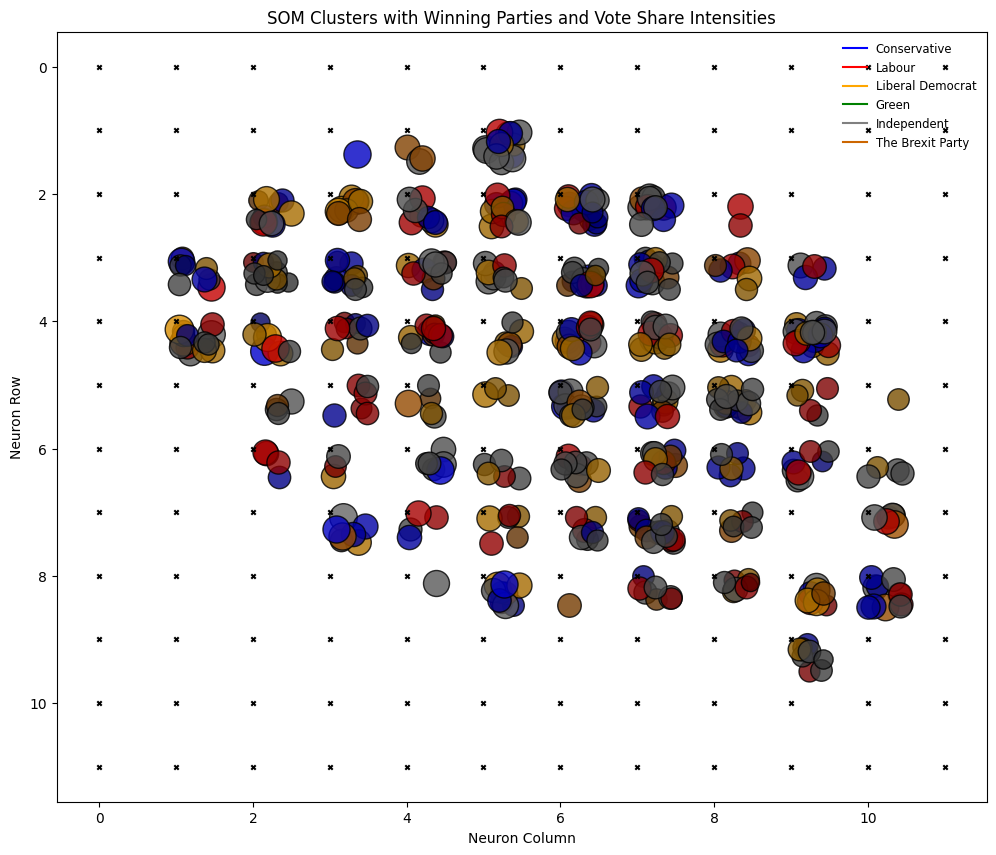

Cluster Summary:


In [7]:

grouped_data = normalized_df.groupby(['Neuron Row', 'Neuron Col']).agg({
    'Winning Party': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',# Dominant party in the cluster
    'Winning Vote Share': 'mean'           # Average vote share
}).reset_index()


# Prepare grid and colors
# u_matrix = som.distance_map()  # U-Matrix shows distances between neurons
plt.figure(figsize=(12, 10))
plt.title("SOM Clusters with Winning Parties and Vote Share Intensities")

# # Plot U-Matrix (background map)
# plt.imshow(u_matrix.T, cmap='bone_r', alpha=0.7)
# plt.colorbar(label='Neuron Distance (U-Matrix)')

# Scatter Plot
for index, row in normalized_df.iterrows():
    r, c = row['Neuron Row'], row['Neuron Col']
    party = row['Winning Party']
    vote_share = row['Winning Vote Share']

    base_color = np.array(party_colors.get(party, (0.5, 0.5, 0.5)))
    adjusted_color = base_color * (vote_share)
    adjusted_color = np.clip(adjusted_color, 0, 1)

    plt.scatter(c + np.random.rand() * 0.5,
                r + np.random.rand() * 0.5,
                s=vote_share * 500,
                color=adjusted_color,
                label=party if index == 0 else "",
                alpha=0.8, edgecolors='k')

# Plot centroids of neurons
centroids = som.get_weights()
for i in range(n_neurons):
    for j in range(m_neurons):
        plt.scatter(j, i, c='k', s=10, marker='x', edgecolors='k')




legend_elements = [Line2D([0], [0], color=party_colors[party], label=party, markersize=10)for party, color in party_colors.items()]


plt.legend(handles=legend_elements, loc='upper right', fontsize='small', frameon=False)
# plt.legend(party_colors.keys(), loc='upper right', fontsize='small', frameon=False)


plt.gca().invert_yaxis()  # Align SOM's convention
# plt.colorbar(label="Vote Share Intensity (scaled size)")
plt.xlabel("Neuron Column")
plt.ylabel("Neuron Row")

plt.show()

# grid_colors = np.zeros((n_neurons, m_neurons, 3))  # RGB grid



# Assign colors based on party and vote share
# for _, row in normalized_df.iterrows():
#     r, c = int(row['Neuron Row']), int(row['Neuron Col'])
#     party = row['Winning Party']
#     weight = max(0.1, row['Winning Vote Share'] / 100)  # Normalize weight (0-1)

#     base_color = party_colors.get(party, (128, 128, 128))
#     weighted_color = tuple(np.clip([component * weight for component in base_color], 0, 1))  # Scale intensity

#     # Add a rectangle patch to indicate the winning neuron color
#     plt.gca().add_patch(Rectangle((c, r), 1, 1, color=weighted_color, ec='white'))




# # Plot SOM Grid

# plt.figure(figsize=(10, 10))
# plt.title("SOM Clusters Colored by Winning Party and Weighted by Vote Share")


# Overlay constituency names for clarity
# for _, row in normalized_df.iterrows():
#     r, c = int(row['Neuron Row']), int(row['Neuron Col'])
#     plt.text(c + 0.5, r + 0.5, row['Winning Party'][:3], fontsize=7,
#              ha='center', va='center', color='white', weight='bold')

# plt.xticks(np.arange(0, m_neurons + 1))
# plt.yticks(np.arange(0, n_neurons + 1))
# plt.gca().invert_yaxis()
# plt.grid()
# plt.show()

# # Add a legend for party colors
# legend_elements = [Line2D([0], [0], color=party_colors[party], lw=4, label=party)
#                    for party in party_colors.keys()]
# plt.legend(handles=legend_elements, loc='upper right', title="Winning Party Colors")

# plt.text(-1, n_neurons + 1, "Intensity reflects the winning vote share %", fontsize=10)


# plt.xlim(0, m_neurons)
# plt.ylim(0, n_neurons)
# plt.gca().invert_yaxis()  # Invert y-axis to match SOM convention
# # plt.colorbar(label='Intensity of Vote Share')
# plt.show()

print("Cluster Summary:")
# print(grouped_data)